<a href="https://colab.research.google.com/github/ri3habh/Generative-Modelling-with-Keras/blob/main/AutoencoderForSmallNorb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

from scipy.stats import norm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
# Parameters...
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

In [73]:
!pip install keras
!pip install tensorflow-datasets

**Prepping the Data**

In [74]:
(x_train, x_test), dataset_info = tfds.load(
    'kmnist',
    split=['train', 'test'],
    as_supervised=True,  # Loads the dataset in a 2-tuple structure [input, label]
    with_info=True,  # Provides a tuple containing info about the dataset
    shuffle_files=True
)

In [75]:
display(x_train)

<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [76]:
import tensorflow as tf
import numpy as np

def convert_to_numpy(tf_dataset):
    x, y = [], []
    for img, label in tfds.as_numpy(tf_dataset):
        x.append(img)
        y.append(label)
    return np.array(x), np.array(y)

x_train, y_train = convert_to_numpy(x_train)
x_test, y_test = convert_to_numpy(x_test)

Preprocessing data to be 32x32...

In [77]:
def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    # Apply padding correctly: ((top, bottom), (left, right), (channel_dim))
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2), (0, 0)), constant_values=0.0)
   # imgs = np.expand_dims(imgs, -1) # adds an extra dimension to the data
    return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)

Build the variational autoencoder

In [85]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [86]:
import keras.models as models

# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 16, 16, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_10 (Conv2D)          (None, 8, 8, 64)             18496     ['conv2d_9[0][0]']            
                                                                                                  
 conv2d_11 (Conv2D)          (None, 4, 4, 128)            73856     ['conv2d_10[0][0]']           
                                                                                            

In [87]:
# Decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 2048)              6144      
                                                                 
 reshape_3 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 8, 8, 128)         147584    
 Transpose)                                                      
                                                                 
 conv2d_transpose_10 (Conv2  (None, 16, 16, 64)        73792     
 DTranspose)                                                     
                                                                 
 conv2d_transpose_11 (Conv2  (None, 32, 32, 32)        1846

In [88]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [89]:
from tensorflow.keras import metrics

# Create a variational autoencoder
vae = VAE(encoder, decoder)

Training the beast

In [90]:
from tensorflow.keras import optimizers

# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [91]:
from tensorflow.keras import callbacks

# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [92]:
import keras.losses as losses

vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/5
600/600 [==============================] - ETA: 0s - total_loss: 164.5109 - reconstruction_loss: 161.2235 - kl_loss: 3.2873

600/600 [==============================] - 211s 347ms/step - total_loss: 164.5109 - reconstruction_loss: 161.2235 - kl_loss: 3.2873 - val_loss: 144.7660 - val_reconstruction_loss: 140.8056 - val_kl_loss: 3.9604
Epoch 2/5
600/600 [==============================] - ETA: 0s - total_loss: 143.4697 - reconstruction_loss: 139.3358 - kl_loss: 4.1339

600/600 [==============================] - 196s 326ms/step - total_loss: 143.4697 - reconstruction_loss: 139.3358 - kl_loss: 4.1339 - val_loss: 143.4235 - val_reconstruction_loss: 139.3252 - val_kl_loss: 4.0983
Epoch 3/5
600/600 [==============================] - ETA: 0s - total_loss: 141.0033 - reconstruction_loss: 136.6435 - kl_loss: 4.3598

600/600 [==============================] - 200s 333ms/step - total_loss: 141.0033 - reconstruction_loss: 136.6435 - kl_loss: 4.3598 - val_loss: 142.1602 - val_reconstruction_loss: 137.7355 - val_kl_loss: 4.4246
Epoch 4/5
600/600 [==============================] - ETA: 0s - total_loss: 139.7401 - reconstruction_loss: 135.2374 - kl_loss: 4.5026

600/600 [==============================] - 196s 326ms/step - total_loss: 139.7401 - reconstruction_loss: 135.2374 - kl_loss: 4.5026 - val_loss: 142.2105 - val_reconstruction_loss: 137.7037 - val_kl_loss: 4.5068
Epoch 5/5
600/600 [==============================] - ETA: 0s - total_loss: 138.8376 - reconstruction_loss: 134.2103 - kl_loss: 4.6273

600/600 [==============================] - 195s 325ms/step - total_loss: 138.8376 - reconstruction_loss: 134.2103 - kl_loss: 4.6273 - val_loss: 141.7341 - val_reconstruction_loss: 137.3557 - val_kl_loss: 4.3784


In [93]:
# Save the final models
vae.save("./models/vae")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

Reconstructing images using our VAE

In [94]:
# Select a subset of the test set
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

Example real images
Reconstructions


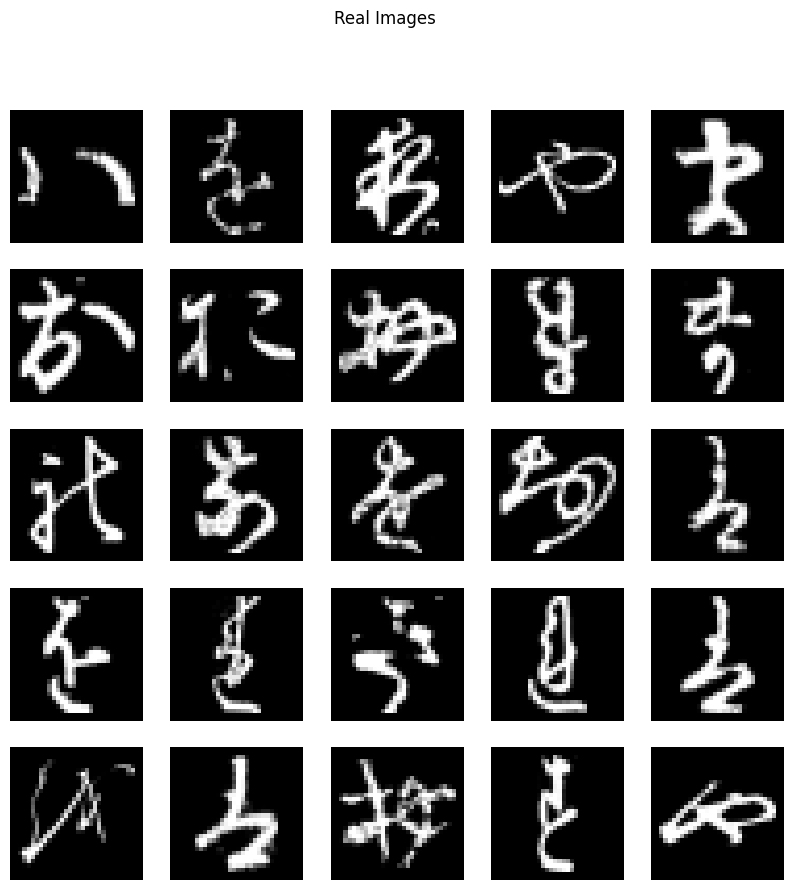

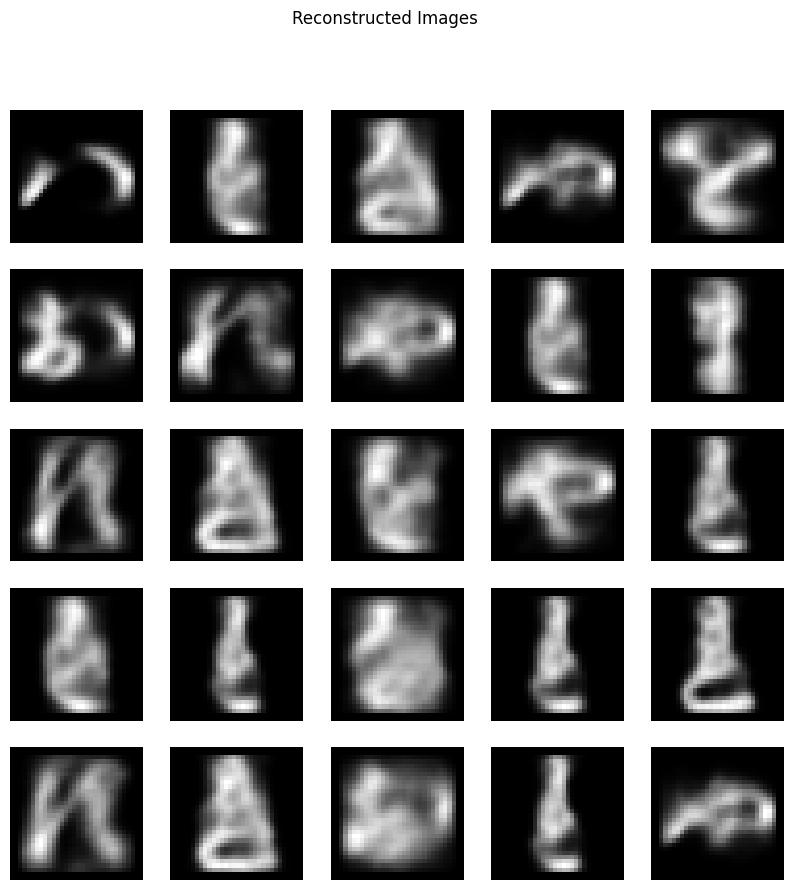

In [97]:
import matplotlib.pyplot as plt

def display_images(images, title):
    plt.figure(figsize=(10, 10))
    for i in range(25):  # Display first 25 images
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')  # Use .squeeze() to remove single-dimensional entries
        plt.axis('off')
    plt.suptitle(title)

# Display a subset of real images
print("Example real images")
display_images(example_images, "Real Images")

# Display reconstructions
print("Reconstructions")
display_images(reconstructions, "Reconstructed Images")


Embed using the encoder

In [98]:
# Encode the example images
z_mean, z_var, z = encoder.predict(example_images)

157/157 [==============================] - 1s 6ms/step


In [99]:
# Some examples of the embeddings
print(z[:10])

[[ 2.2661533  -1.070113  ]
 [-0.8699584   0.5722027 ]
 [-1.0390393  -0.10679619]
 [ 1.4452097  -0.65454626]
 [-0.07725288  0.57579195]
 [ 0.50428575 -1.1849794 ]
 [-0.84198284 -1.8821708 ]
 [ 0.65191054 -0.6210796 ]
 [-0.88181365  0.5776444 ]
 [ 0.05065635  1.046483  ]]


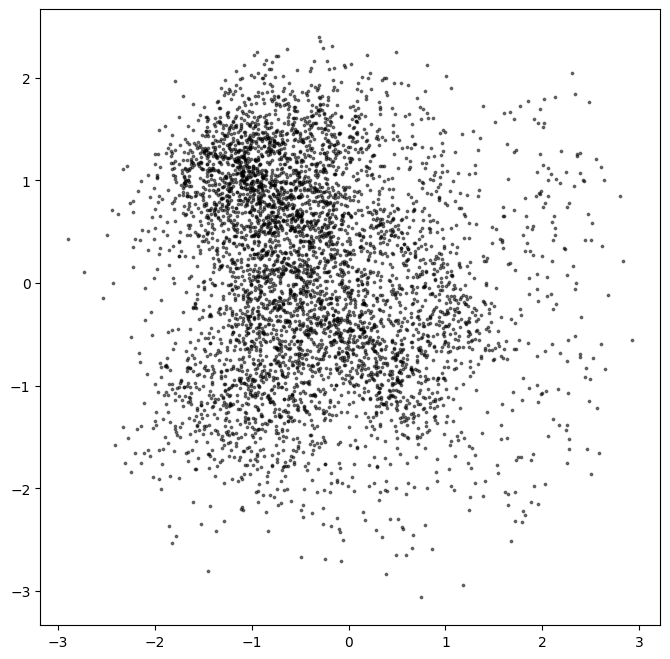

In [100]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

Generating new images using the decoder...

In [101]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [102]:
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 0s 367ms/step


In [103]:
# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

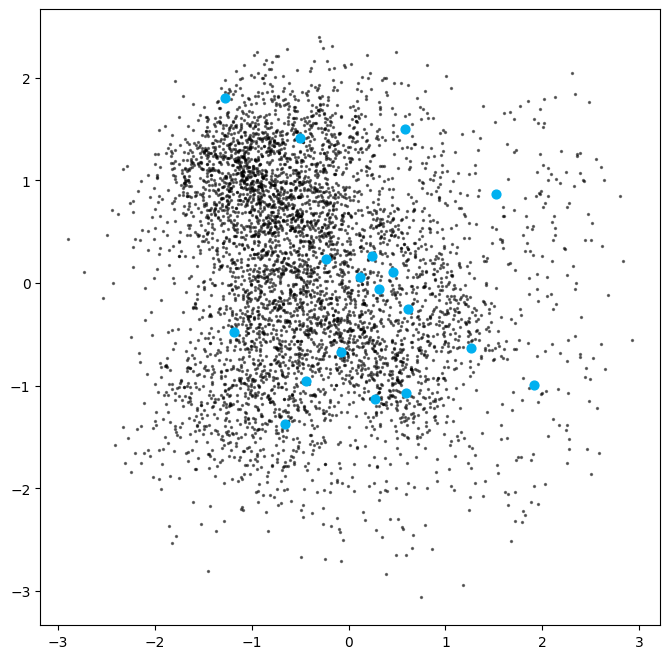

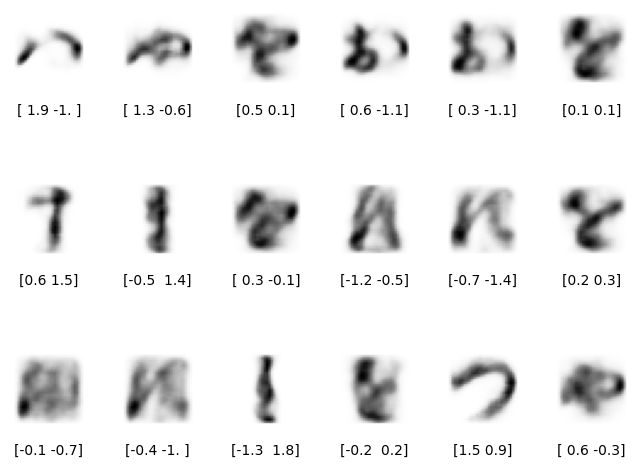

In [104]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

Exploring the latent space... 🚀🚀🚀🌌☄️🛰️

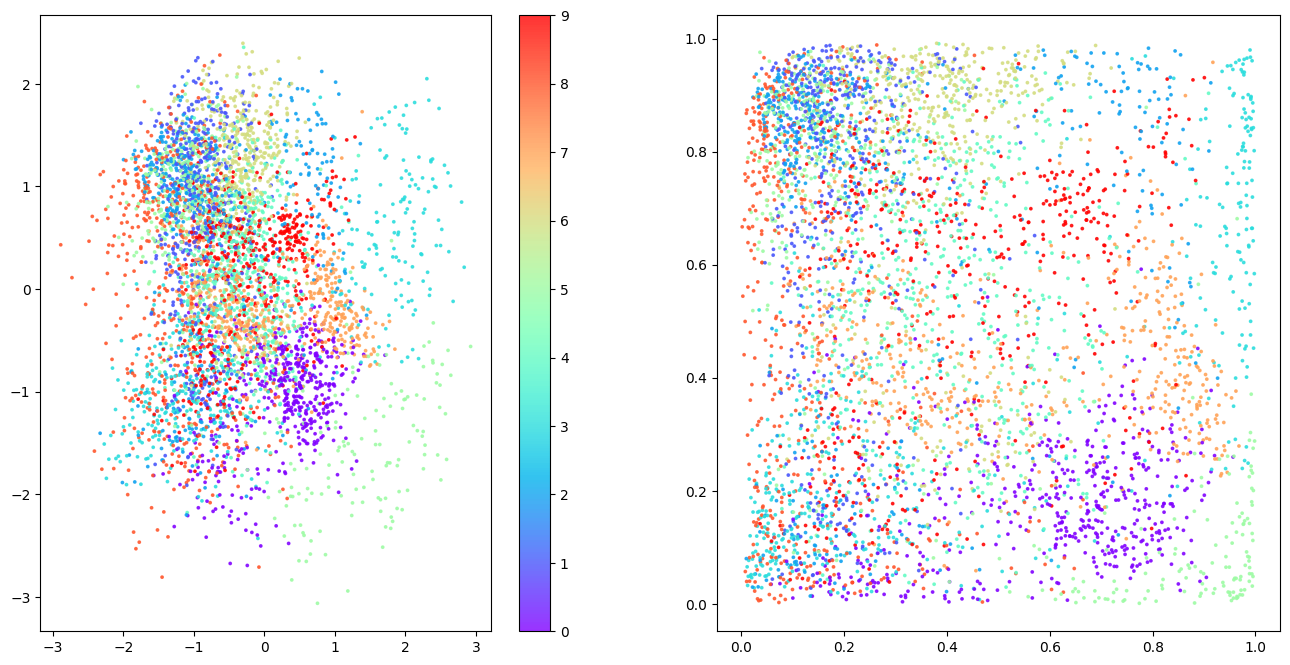

In [105]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

Above, we have 10 different colours for the 10 different numbers

8/8 [==============================] - 0s 27ms/step


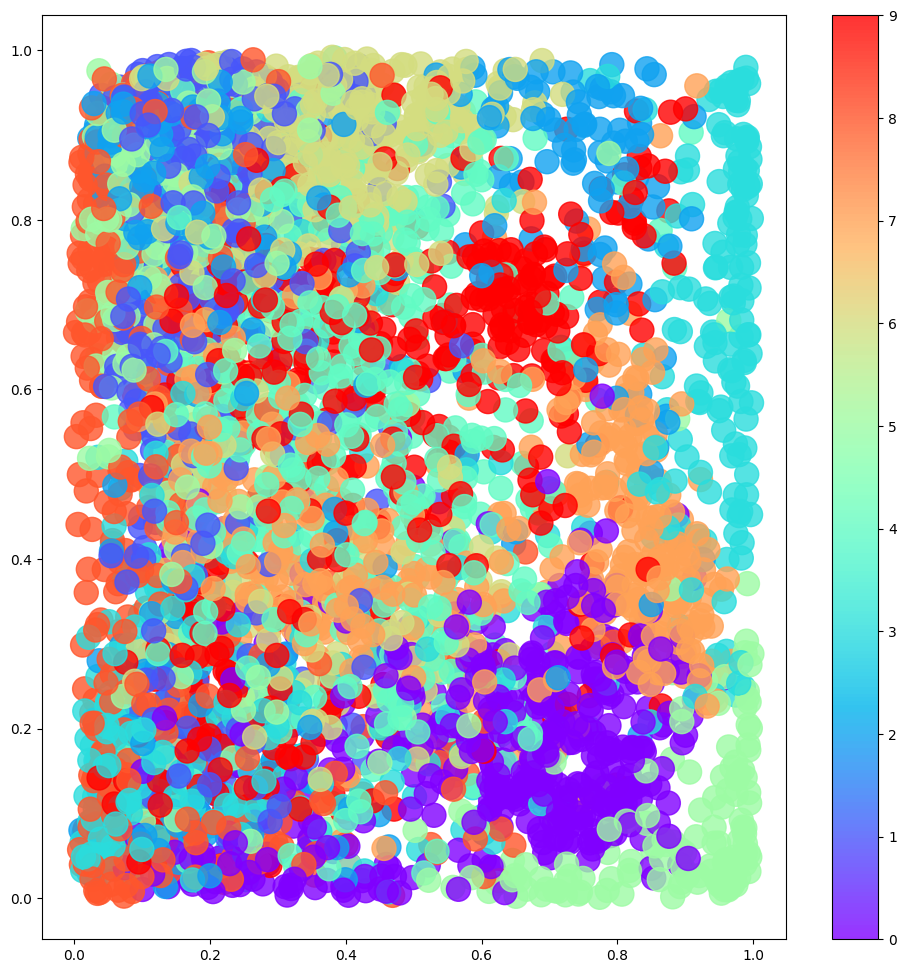

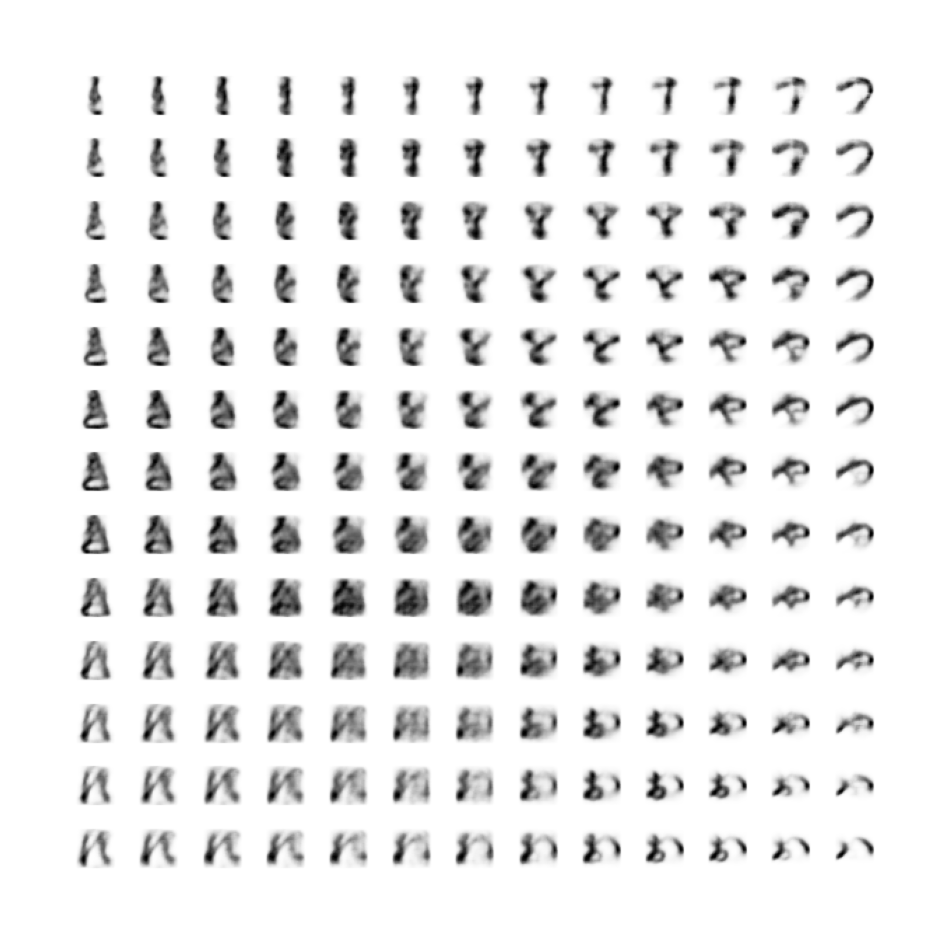

In [106]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")